In [ ]:
!pip install netCDF4

In [ ]:
!pip install scipy

In [ ]:
!pip install pandas

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.3.0+cu118.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.3.0+cu118.html
!pip install torch-geometric

In [29]:
import os
import pandas as pd
import numpy as np

In [30]:
# Dependencies for data extraction
import netCDF4 as NC
import glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
#from numpy.fft import fft, ifft
from scipy.signal import welch
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftfreq

In [31]:
path = os.getcwd()
path=os.path.join(path,"data")
temporary = os.listdir(path)
data_files = glob.glob(path+os.sep+'hyd_temp_*.nc')
print(data_files)

A=[]
U=[]

time = np.empty([0])
Temperature_values_loc = np.empty([0])
a_smallest = 321768
u_smallest = 321768

for i in range(len(data_files)):
    Data_filename = NC.Dataset(data_files[i],'r')
    # print(Data_filename['plevel'][0])
    if i%2==0:
      #Temperature_values_loc_a = np.append(Temperature_values_loc_a, Data_filename['TMP_prl'][:,0,1,1])
      #time_a = np.append(time_a, Data_filename['time'])
      A.append(Data_filename['TMP_prl'][:,0,1,1])

      a_smallest = min(a_smallest,len(A[-1]))

    else:
      # Temperature_values_loc_u = np.append(Temperature_values_loc_u, Data_filename['TMP_prl'][:,0,1,1])
      # time_u = np.append(time_u, Data_filename['time'])
      U.append(Data_filename['TMP_prl'][:,0,1,1])

      u_smallest = min(u_smallest, len(U[-1])) 

#temp_data = list(zip(time,Temperature_values_loc))
#temp_df=pd.DataFrame(temp_data ,columns=["time","Temperature"])

for i in range(8):
      A[i]=A[i][:a_smallest]
      U[i]=U[i][:u_smallest]

# for month:-
a_month=[]
u_month=[]

A=np.array(A)
U=np.array(U)

temp1=A[:][:2880]
temp2=U[:][:2880]

a_num=0
u_num=0

for i in range(16):
  if i%2==0:
    for j in range(12):
      if j%2==0:
        a_month.append(temp1[a_num][240*j:240*(j+1)])
            
      else:
        u_month.append(temp1[a_num][240*j:240*(j+1)])
      
    a_num=a_num + 1

  else:
    for j in range(12):
      if j%2==0:
        a_month.append(temp2[u_num][240*j:240*(j+1)])
    
      else:
        u_month.append(temp2[u_num][240*j:240*(j+1)])

    u_num=u_num+1

a_month=np.array(a_month)
u_month=np.array(u_month)

# for day:
a_day=[]
u_day=[]

a_num=0
u_num=0

# We will loop through each year and through each month, assuming each month has 30 days
for i in range(192): # Since we are looping through the yearly data having 192 samples 
  if i%2==0:
    for j in range(30):
      if j%2==0:
        a_day.append(a_month[a_num][8*j:8*(j+1)])
            
      else:
        u_day.append(u_month[a_num][8*j:8*(j+1)])
      
    a_num=a_num + 1

  else:
    for j in range(30):
      if j%2==0:
        a_day.append(a_month[u_num][8*j:8*(j+1)])
    
      else:
        u_day.append(u_month[u_num][8*j:8*(j+1)])

    u_num=u_num+1

a_day=np.array(a_day)
u_day=np.array(u_day)

a_ran = []
u_ran = []

i_ran = [7, 8, 9]  # 2 corresponds to March, 3 to April and so on, since 0 is Jan

for i in range(192): # Since we are looping through the yearly data having 192 samples 
  if i%12 in i_ran:
      a_ran.append(a_month[i%12])
    
      u_ran.append(u_month[(i+1)%12])

a_ran = np.array(a_ran)
u_ran = np.array(u_ran)

a_ran_day = []
u_ran_day = []

for i in range(16*len(i_ran)): # Since we are looping through the yearly data having 192 samples 
    for j in range(29):
        a_ran_day.append(a_ran[i][8*j:8*(j+1)])
        u_ran_day.append(u_ran[i][8*(j+1):8*(j+2)])
      
a_ran_day = np.array(a_ran_day) 
u_ran_day = np.array(u_ran_day)  

['c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1990.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1991.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1992.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1993.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1994.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1995.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML projects\\SLP\\data\\hyd_temp_1996.nc', 'c:\\Users\\ASUS\\OneDrive - Indian Institute of Technology Bombay\\Machine Learning\\ML project

In [32]:
a = a_month
u = u_month

In [33]:
for i in range(u.shape[0]):
    a_mean = np.mean(a[i,:])
    a_std = np.std(a[i,:])

    u_mean = np.mean(u[i,:])
    u_std = np.std(u[i,:])

    a[i] = (a[i] - a_mean)/a_std
    u[i] = (u[i] - u_mean)/u_std

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [35]:
from torch_geometric.nn import GCNConv
from torch.utils.data import TensorDataset

In [47]:
# Define a simple Graph Neural Network model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [48]:
# Generate synthetic dataset with initial conditions and final conditions
def generate_dataset(a, u):
    initial_conditions = a
    final_conditions = u
    return initial_conditions, final_conditions

In [75]:
# Parameters
num_samples = a_month.shape[0]
num_nodes = a_month.shape[-1]
num_times = 20  # Number of time steps
input_dim = 1  # Each node represents a temperature value
output_dim = 1
hidden_dim = 32
batch_size = 32
epochs = 15
learning_rate = 0.01

In [76]:
# Generate synthetic dataset
initial_conditions, final_conditions = generate_dataset(a_month, u_month)

# Convert data to PyTorch tensors
initial_conditions_tensor = torch.tensor(initial_conditions, dtype=torch.float)
final_conditions_tensor = torch.tensor(final_conditions, dtype=torch.float)

# Create a PyTorch dataset and dataloader
dataset = TensorDataset(initial_conditions_tensor, final_conditions_tensor)


In [77]:
# Initialize model, optimizer, and loss function
model = GNNModel(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [78]:
# Define evaluation function
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for initial_condition, final_condition in dataloader:
            predicted_final_condition = model(initial_condition.unsqueeze(-1))
            loss = criterion(predicted_final_condition, final_condition.unsqueeze(-1))
            total_loss += loss.item()*32 # Multiply by batch size
    return total_loss / len(dataloader.dataset)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(epochs):
    model.train()
    for initial_condition, final_condition in train_loader:
        optimizer.zero_grad()
        predicted_final_condition = model(initial_condition.unsqueeze(-1))
        loss = criterion(predicted_final_condition, final_condition.unsqueeze(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}')

    # Evaluate the model on the validation set
    val_loss = evaluate(model, criterion, val_loader)
    print(f'Validation Loss: {val_loss}')

Epoch 1, Training Loss: 0.9450803995132446
Validation Loss: 1.4102423667907715
Epoch 2, Training Loss: 0.7841421961784363
Validation Loss: 1.1993066787719726
Epoch 3, Training Loss: 0.6824485659599304
Validation Loss: 1.08602294921875
Epoch 4, Training Loss: 0.6854615211486816
Validation Loss: 1.0223959922790526
Epoch 5, Training Loss: 0.7204023003578186
Validation Loss: 0.9836750984191894
Epoch 6, Training Loss: 0.5962164998054504
Validation Loss: 0.9535300254821777
Epoch 7, Training Loss: 0.5357286334037781
Validation Loss: 0.9322952270507813
Epoch 8, Training Loss: 0.5893236398696899
Validation Loss: 0.9193462371826172
Epoch 9, Training Loss: 0.599073052406311
Validation Loss: 0.9107219696044921
Epoch 10, Training Loss: 0.5803968906402588
Validation Loss: 0.9046088218688965
Epoch 11, Training Loss: 0.5028895139694214
Validation Loss: 0.8993471145629883
Epoch 12, Training Loss: 0.6043612360954285
Validation Loss: 0.8968402862548828
Epoch 13, Training Loss: 0.5822323560714722
Validati

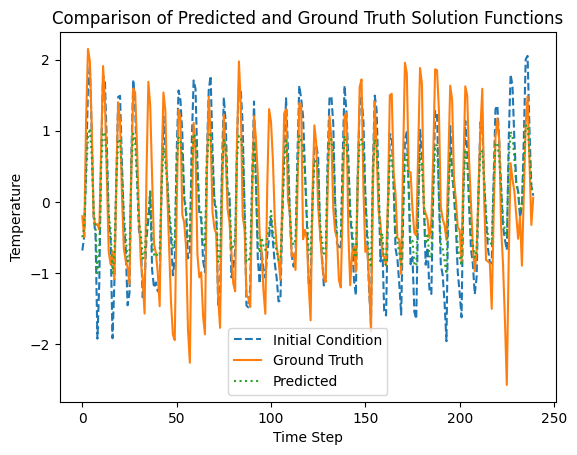

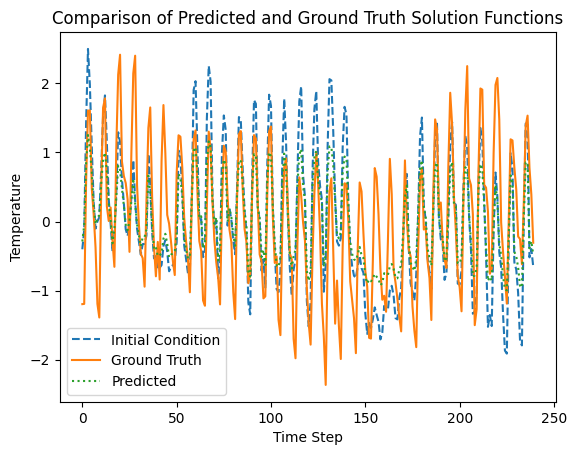

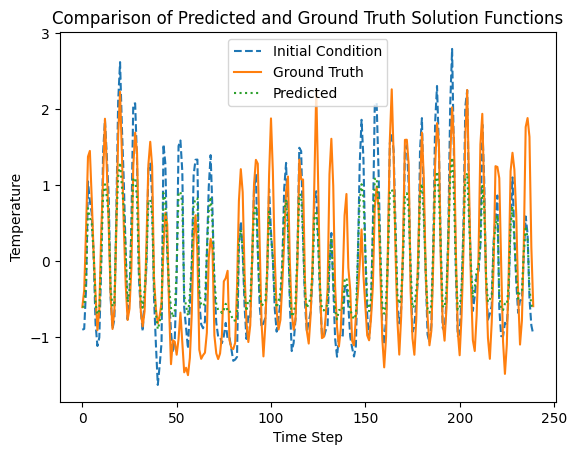

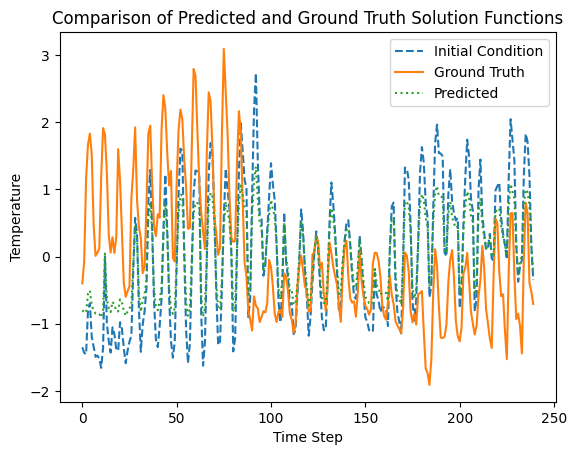

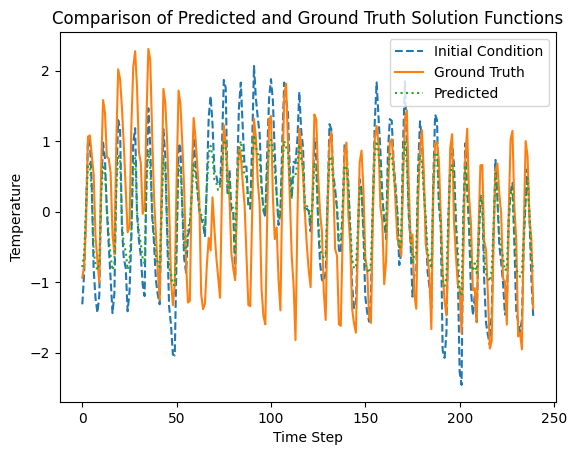

In [79]:
import matplotlib.pyplot as plt

# Function to plot predicted and ground truth solution functions
def plot_results(model, dataloader):
    model.eval()
    with torch.no_grad():
        for initial_condition, final_condition in dataloader:
            predicted_final_condition = model(initial_condition.unsqueeze(-1))
            for i in range(5):
                plt.plot(initial_condition[i], label='Initial Condition', linestyle='--')
                plt.plot(final_condition[i], label='Ground Truth', linestyle='-')
                plt.plot(predicted_final_condition[i], label='Predicted', linestyle=':')
                plt.xlabel('Time Step')
                plt.ylabel('Temperature')
                plt.title('Comparison of Predicted and Ground Truth Solution Functions')
                plt.legend()
                plt.show()

# Plot results on validation data
plot_results(model, val_loader)


In [80]:
# Calculate Mean Squared Error (MSE) on validation data
val_mse = evaluate(model, criterion, val_loader)
print(f'Validation MSE: {val_mse}')

Validation MSE: 0.8929841995239258
